<a href="https://colab.research.google.com/github/ganesh3/pytorch-work/blob/master/CNN_Pytorch_CIFAR10_Feature_Maps.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Building a Convolutional Neural Network in PyTorch

### The below code is based on the [link](https://machinelearningmastery.com/building-a-convolutional-neural-network-in-pytorch/) from machine learning mastery and is a copy of the article. I am just rewriting the code to learn.

Convolutional neural network is to use convolutional layers to preserve spatial information of pixels. It learns how alike are the neighboring pixels and generating feature representations. What the convolutional layers see from the picture is invariant to distortion in some degree. For example, a convolutional neural network could predict the same result even if the input image has shift in color, rotated or rescaled. Moreover, convolutional layers has fewer weights, thus easier to train.

Building Blocks of Convolutional Neural Networks

The simplest use case of a convolutional neural network is for classification. You will find it to contain three types of layers:

    1. Convolutional layers
    2. Pooling layers
    3. Fully-connected layers

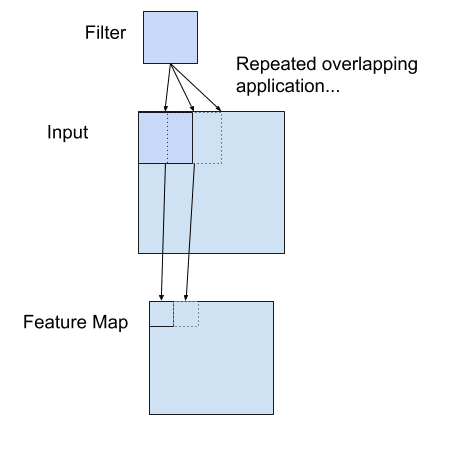

The output of a convolutional layer is called feature maps because usually it learned about the features of the input image. For example, whether there are vertical lines at the position. Learning the features from pixels is to help understanding the image at a higher level. Multiple convolutional layers are stacked together in order to infer higher level features from lower level details.

Pooling layer is to downsample the previous layer’s feature map.

Fully connected layers are usually the final layers in a network. It is to take the features consolidated by previous convolutional and pooling layers as input to produce prediction. There might be multiple fully connected layers stacked together. In the case of classification, you usually see the output of the final fully connected layer applied with a softmax function to produce probability-like classification.

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision

In [2]:
transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])

In [3]:
# The CIFAR-10 dataset provides images in 32×32 pixels in RGB color (i.e., 3 color channels). There are 10 classes, labelled in integers 0 to 9
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=False, transform=transform)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data


In [4]:
batch_size = 32
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=True)

In [5]:
class CIFAR10Model(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(3, 32, kernel_size=(3,3), stride=1, padding=1)
    self.act1 = nn.ReLU()
    self.drop1 = nn.Dropout(0.3)

    self.conv2 = nn.Conv2d(32, 32, kernel_size=(3,3), stride=1, padding=1)
    self.act2 = nn.ReLU()
    self.pool2 = nn.MaxPool2d(kernel_size=(2,2))

    self.flat = nn.Flatten()

    self.fc3 = nn.Linear(8192, 512)
    self.act3 = nn.ReLU()
    self.drop3 = nn.Dropout(0.5)

    self.fc4 = nn.Linear(512, 10)

  def forward(self, x):
    # input 3x32x32, output 32x32x32
    x = self.act1(self.conv1(x))
    x = self.drop1(x)
    # input 32x32x32, output 32x32x32
    x = self.act2(self.conv2(x))
    # input 32x32x32, output 32x16x16
    x = self.pool2(x)
    # input 32x16x16, output 8192
    x = self.flat(x)
    # input 8192, output 512
    x = self.act3(self.fc3(x))
    x = self.drop3(x)
    # input 512, output 10
    x = self.fc4(x)
    return x

In [6]:
# initialize the model, loss, and optimizer
model = CIFAR10Model()
loss = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr = 0.001, momentum=0.9)

In [7]:
# train the model
n_epoch = 20
for epoch in range(n_epoch):
  for inputs, labels in trainloader:
    model.train()
    y_pred = model(inputs)
    loss_fn = loss(y_pred, labels)
    optimizer.zero_grad()
    loss_fn.backward()
    optimizer.step()

  acc = 0
  count = 0
  for input, labels in testloader:
    model.eval()
    y_test_pred = model(input)
    # accuracy of classification is more intuitive than cross entropy, 
    # which is computed at the end of each epoch, by comparing the maximum value in the output logit to the dataset’s labels
    acc += (torch.argmax(y_test_pred, 1) == labels).float().sum()
    count += len(labels)
  acc /= count
  print("Epoch %d: model accuracy %.2f%%" % (epoch, acc*100))

Epoch 0: model accuracy 37.47%
Epoch 1: model accuracy 42.61%
Epoch 2: model accuracy 45.61%
Epoch 3: model accuracy 49.46%
Epoch 4: model accuracy 51.78%
Epoch 5: model accuracy 53.70%
Epoch 6: model accuracy 54.68%
Epoch 7: model accuracy 57.31%
Epoch 8: model accuracy 58.69%
Epoch 9: model accuracy 60.17%
Epoch 10: model accuracy 61.32%
Epoch 11: model accuracy 62.22%
Epoch 12: model accuracy 63.30%
Epoch 13: model accuracy 64.45%
Epoch 14: model accuracy 64.26%
Epoch 15: model accuracy 65.31%
Epoch 16: model accuracy 66.02%
Epoch 17: model accuracy 66.67%
Epoch 18: model accuracy 66.96%
Epoch 19: model accuracy 67.57%


In [10]:
torch.save(model.state_dict(), "cifar10model.pth")

# What Are in Feature Maps?

There are two convolutional layers in the network defined above. They are both defined with kernel size of 3×3, hence it is looking at 9 pixels at a time to produce one output pixel. Note that the first convolutional layer is taking the RGB image as input. Hence each pixel has three channels. The second convolutional layer is taking a feature map with 32 channels as input. Each “pixel” as it sees will have 32 values. Thus the second convolutional layer has more parameters even they have the same receptive field.

Let’s see what is in the feature map. Let’s say we pick one input sample from the training set:

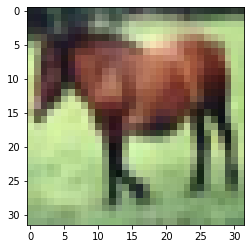

In [13]:
import matplotlib.pyplot as plt

# You can see that this is an image of a horse, in 32×32 pixels with RGB channels: 
plt.imshow(trainset.data[7])
plt.show()

In [14]:
X = torch.tensor([trainset.data[7]], dtype=torch.float32).permute(0,3,1,2)

<ipython-input-14-7fc7624f1765>:1: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:230.)
  X = torch.tensor([trainset.data[7]], dtype=torch.float32).permute(0,3,1,2)


In [16]:
X.shape

torch.Size([1, 3, 32, 32])

In [17]:
model.eval()
with torch.no_grad():
    feature_maps = model.conv1(X)

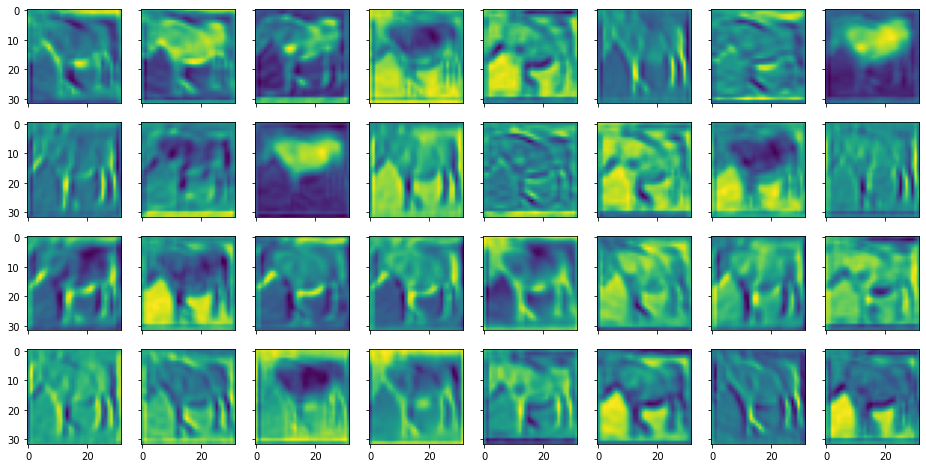

In [20]:
# feature maps are highlighting certain features from the input image. A feature is identified using a small window (in this case, over a 3×3 pixels filter). 
fig, ax = plt.subplots(4, 8, sharex=True, sharey=True, figsize=(16,8))
for i in range(0, 32):
    row, col = i//8, i%8
    ax[row][col].imshow(feature_maps[0][i])
plt.show()

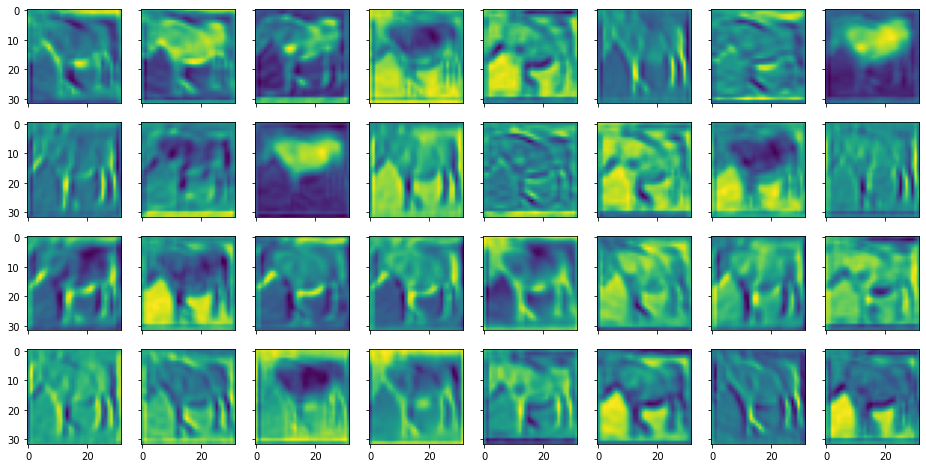

In [19]:
X = torch.tensor([trainset.data[7]], dtype=torch.float32).permute(0,3,1,2)
 
model.eval()
with torch.no_grad():
    feature_maps = model.act1(model.conv1(X))
    feature_maps = model.drop1(feature_maps)
    feature_maps = model.conv2(feature_maps)
 
fig, ax = plt.subplots(4, 8, sharex=True, sharey=True, figsize=(16,8))
for i in range(0, 32):
    row, col = i//8, i%8
    ax[row][col].imshow(feature_maps[0][i])
plt.show()

Compared to the output of the first convolutional layer, the feature maps from the second convolutional layer looks blurry and more abstract. But these are more useful for the model to identify the objects.